# Philly Bail Fund
## Analysis of factors related to Bail Amounts

For more details, see the github repo: https://github.com/CodeForPhilly/pbf-analysis

[insert overview of approach here.. img?]

*__IMPORTANT__*: There are several factors that we can't control for, because the data is not available. This means that drawing conclusions from any correlations should not be assumed to be causal. Use with caution!
Mainly,
* Criminal history
* Magistrate that sets the bail
* 


__ITEMS FOR FOLLOW UP__

[ ] Is there a set of legal criteria or guidance for setting bail

[X] Is filing date really the time/day that bail is set?  - YES (7/16 - @alinder)

### Imports

In [1]:
# PEP8 fans please close your eyes
import pandas as pd, numpy as np, os, re, json, pickle, math, calendar, eli5, joblib
from time import time
from pprint import pprint
from pathlib import Path
from datetime import datetime
from eli5.sklearn import PermutationImportance

#charting
import seaborn as sns
import matplotlib.pyplot as plt

### Display options for notebooks
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 25)

### set path directories
curr_dir = Path(os.getcwd())
#print('Current Directory is: ', str(curr_dir))
data_dir = Path(curr_dir.parents[0] / 'Data/')
artifacts_dir = Path(curr_dir / 'artifacts/')

/Users/josh.berry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/josh.berry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/josh.berry/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.

In [2]:
### Common project specific variables
FILENAME = '0c_distinct_dockets.csv'  # original data
TARGET_VARIABLE_NAME = 'bail_amount'
HOLDOUT_INDICATOR_NAME = 'holdout_ind'
DATECOL = 'filing_date'
HOLDOUT_SIZE = 0.80

### Helper Functions

In [3]:
# helper function to reduce memory footprint of the dataframe
def reduce_mem_usage(df, verbose=True):
    import numpy as np
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Data Import

In [4]:
# read in the data and take a peek at it
indata = pd.read_csv(Path(data_dir) / FILENAME, parse_dates=['filing_date'], index_col='id')

indata.head(3)

,age,address,docket_number,filing_date,charge,represented_by,bail_type,bail_status,bail_amount,outstanding_bail_amount
id,,,,,,,,,,
3909,27.0,"Philadelphia, PA 19141",MC-51-CR-0011746-2020,2020-06-16 00:37:00+00:00,DUI: Gen Imp/Inc of Driving Safely - 1st Off,Defender Association of Philadelphia,Posted,ROR,0,0
4538,44.0,"Philadelphia, PA 19124",MC-51-CR-0011747-2020,2020-06-16 00:41:00+00:00,Verify Address or Photographed as Required,Defender Association of Philadelphia,Set,Monetary,50000,0
120,24.0,"Philadelphia, PA 19142",MC-51-CR-0011743-2020,2020-06-16 00:52:00+00:00,Criminal Mischief,Defender Association of Philadelphia,Posted,ROR,0,0


### Data Setup

After importing the data, our first step is to remove anything that may be unecessary for analysis. However, we can extract some useful information from the date field before dropping it. And lastly, we have data for situations for which there is no bail - so we are going to remove those rows with 0 bail from this point forward.

It may be worth an exercise to predict Bail Yes/no and do another analysis. However this notebook is starting off as limited to the bail amount that is being set.

__Steps__ 

__A1.__ Keep = bail_amount, charge, bail_status, filing_date, age, represented_by

__A2.__ Create hour of day and day of week from filing_date, then drop originial filing_date

__A3.__ Delete rows where bail_status = 'Denied' (we will only worry about ones where there is a set amount)

##### A1: Keep only columns that might impact the bail amount

In [5]:
# drop things we know aren't useful
drop_list = ['address','docket_number','bail_type','outstanding_bail_amount']

indata.drop(columns=drop_list, inplace=True, errors='ignore')

##### A2: Parse Hour of Day and Day of Week, before dropping the date field

In [6]:
# hour of day
indata['filed_hour_of_day'] = indata[DATECOL].dt.hour

# day of the week with Monday=0, Sunday=6
indata['filed_day_of_week'] = indata[DATECOL].dt.dayofweek.apply(lambda x: calendar.day_abbr[x])

indata.drop(columns=[DATECOL], inplace=True, errors='ignore')

indata['charge'] = indata['charge'].str.lower().str.replace('[^\w\s]','')

##### A3: Remove rows where bail does not apply

In [7]:
# remove rows where bail amount is more than zero
clean = indata[indata['bail_amount']>0]

clean.head(5)

,age,charge,represented_by,bail_status,bail_amount,filed_hour_of_day,filed_day_of_week
id,,,,,,,
4538,44.0,verify address or photographed as required,Defender Association of Philadelphia,Monetary,50000,0,Tue
291,32.0,contempt for violation of order or agreement,Defender Association of Philadelphia,Monetary,50000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
2396,51.0,simple assault,Defender Association of Philadelphia,Unsecured,25000,1,Tue


### Load Models Objects

In order to analyze effects of each item on `bail_amount`, we'll need to build a model that predicts it. This was all done in [another notebook]. Here, we'll simply import these models and then we can start our analysis on the various effects. These were trained using a Random Forest regressor with an ElasticNet submodel built from words in the charges column. See [other notebook] for details.

In [20]:
submodel = joblib.load(Path(artifacts_dir) / 'text_submodel.mdl')
mainmodel = joblib.load(Path(artifacts_dir) / 'model.mdl')
cols = list(joblib.load(Path(artifacts_dir) / 'model_col_order.list'))

NOTE: I am having problems doing this permutation importance elegantly,.... and some of it has to do w/ a column ordering.

I posted this question on stack overflow awaiting an answer: https://stackoverflow.com/questions/63020955/confused-about-column-order-for-sklearn-pipeline-imputer

In [45]:
# use submodel to add replace the charge field with a number
x = clean[cols].copy()
y = clean[TARGET_VARIABLE_NAME].copy()

x['charge'] = submodel.predict(x[['charge']])

# break out estimator and imputer because thats how eli5 needs it
estimator = mainmodel.named_steps['final_model']
imputer = mainmodel.named_steps['preprocessor']

x_transformed = imputer.transform(x[cols])

x_transformed_col_order = ['age','represented_by','bail_status','filed_hour_of_day','filed_day_of_week','charge']

df_x_transformedx_transformed = pd.DataFrame(x_transformed, columns=cols)
#scored = pd.DataFrame(estimator.predict(x_transformed), columns=x_transformed_col_order)

In [46]:
df_x_transformedx_transformed

,age,charge,represented_by,bail_status,filed_hour_of_day,filed_day_of_week
0,44.0,2.0,1.0,0.0,3.0,81528.266846
1,32.0,2.0,1.0,1.0,3.0,26414.244599
2,32.0,2.0,1.0,1.0,3.0,41815.938860
3,32.0,2.0,1.0,1.0,3.0,41815.938860
4,51.0,2.0,2.0,1.0,3.0,21258.875926
...,...,...,...,...,...,...
4092,34.0,2.0,1.0,19.0,5.0,111414.484937
4093,23.0,2.0,1.0,21.0,5.0,81449.959180
4094,22.0,2.0,1.0,21.0,5.0,81449.959180
4095,29.0,1.0,2.0,21.0,5.0,113089.939546


In [47]:
imputer

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['age']),
                                ('cat1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ord_encoding',
                                                  OrdinalEncoder())]),
                                 ['represented_by', 'bail_status',
                                  'filed_hour_of_day', 'filed_day_of_week'])])

### Analysis

E1. Matrix of correlation (mutual information?) to prove these are independent variables

E2. Permutation Importance to show the relative importance of each variable in the model (this is a better interpretation than the tree-importance that comes from the model itself)

E3. Partial Dependence Plots for each of the variables (except the text)

E4. Score original training dataset with model. Filter for observations where predicted value is either top 10% or bottom 10%. Run SHAP to extract #1 reason for each observation in the top/bottom 10%.

E5. Look for any cases where age, represented_by is the #1 factor for the bail_amount. These could be interesting cases to highlight

E6. Word cloud of the terms - this could take some work I'm not too familiar w/ this


##### E1: Correlation Matrix 
Can we use Mutual Information ?

In [ ]:
# I did check this in external tools and prove that they are independent - I just need to find time to code this in python and make a nice graphic

##### E2: Feature Impact

In [34]:




perm = PermutationImportance(estimator, random_state=1, cv=None)

perm.fit(x2, y)

eli5.explain_weights_df(perm, feature_names = newcolorder)

,feature,weight,std
0,charge,0.866473,0.016826
1,filed_hour_of_day,0.366512,0.021344
2,age,0.240054,0.020387
3,filed_day_of_week,0.151401,0.007490
4,bail_status,0.147059,0.007213
5,represented_by,0.123575,0.005762


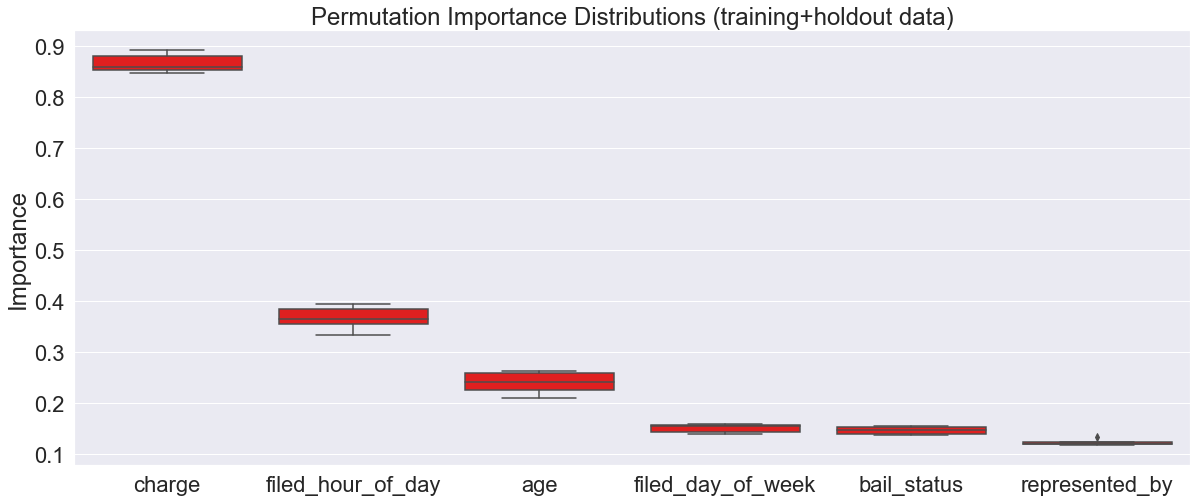

In [37]:
sns.set(font_scale=2)

# plot the distributions
perm_train_feat_imp_df = pd.DataFrame(data=perm.results_,columns=newcolorder)

# i could probably reorder these better
perm_train_feat_imp_df = perm_train_feat_imp_df[['charge','filed_hour_of_day','age','filed_day_of_week','bail_status','represented_by']]

plt.figure(figsize=(20,8))

(sns.boxplot(data=perm_train_feat_imp_df, color='Red')
        .set(title='Permutation Importance Distributions (training+holdout data)',
             ylabel='Importance'));

In [ ]:
plt.figure(figsize=(20,8))

(sns.barplot(data=perm_train_feat_imp_df, color='Blue')
        .set(title='Permutation Importance Ranking (training+holdout data)',
             ylabel='Importance'));

--------------------------------
#### Everything below this line is untested and scratch code that I stole from a website
--------------------------------

In [38]:
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

from concurrent.futures import ProcessPoolExecutor

def multiproc_iter_func(max_workers, an_iter, func, item_kwarg, **kwargs):
    """
    A helper functions that applies a function to each item in an iterable using
    multiple processes. 'item_kwarg' is the keyword argument for the item in the
    iterable that we pass to the function.
    """
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        
        future_results = [executor.submit(func, **{item_kwarg: item}, **kwargs)
                          for item in an_iter]

        
        results = [future.result() for future in future_results]
        
    df = pd.concat(results, ignore_index=True)
        
    return df

# Contibrutions for all predictions
# Note the multiprocess counter is the first argument for faster processing
train_expl_df = multiproc_iter_func(4, x2, 
                                      eli5.explain_prediction_df, 'doc',
                                      estimator=estimator, 
                                      feature_names=newcolorder)

Process ForkProcess-4:
Traceback (most recent call last):
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
Process ForkProcess-3:
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Traceback (most recent call last):
  File "/Users/josh.berry/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/josh.berry/opt/anaconda3/lib/pytho

KeyboardInterrupt: 

In [ ]:
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
sampl = train_expl_df.sample(n=1000)

In [ ]:
# a hacky function that plots a swarmplot along with a colorbar
# based off the code found here:
# https://stackoverflow.com/questions/40814612/map-data-points-to-colormap-with-seaborn-swarmplot
def swarmplot_with_cbar(cmap, cbar_label, *args, **kwargs):
    fig = plt.gcf()
    ax = sns.swarmplot(*args, **kwargs)
    # remove the legend, because we want to set a colorbar instead
    ax.legend().remove()
    ## create colorbar ##
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.05)
    fig.add_axes(ax_cb)
    cb = ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    cb.set_label(cbar_label, labelpad=10)
    
    return fig
plt.figure(figsize=(20,8))
# min-max scaling of the feature values allows us to use a colorbar
# to indicate high or low feature values
train_scaled_feat_vals = (train_expl_df.groupby('feature')
                                       .value
                                       .transform(lambda x: x/x.max()))

train_expl_df['scaled_feat_vals'] = train_scaled_feat_vals

cmap = plt.get_cmap('viridis')
cbar_label = 'Feature Value %ile'

plt.title('Distribution of Feature Contributions (training data)')


swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
                    hue='scaled_feat_vals', palette='viridis', order=cols,
                    data=sampl.loc[sampl.feature!='']);

In [ ]:
fg = sns.lmplot(x='value', y='contribution', col='feature',
                data=train_expl_df.loc[train_expl_df.feature!=''], 
                col_order=cols, sharex=False, col_wrap=3, fit_reg=False,
                size=4, scatter_kws={'color':'salmon', 'alpha': 0.5, 's':30})
fg.fig.suptitle('Feature Contributions vs Feature Values (training data)')
fg.fig.subplots_adjust(top=0.90);

##### E3: Feature Effects
Partial Dependence Plots

In [ ]:
from pycebox.ice import ice, ice_plot
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from skll.metrics import spearman

# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the players
spearman_scorer = make_scorer(spearman)

# the modeling pipeline
pipe = Pipeline([("estimator", RandomForestRegressor(random_state=444444))])

# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
    'estimator__max_features': (1, 8),
    'estimator__n_estimators': (50, 500), 
    'estimator__min_samples_split': (2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                      rf_param_space, 
                      cv=10,
                      n_jobs=-1, 
                      verbose=0, 
                      error_score=-9999, 
                      scoring=spearman_scorer, 
                      random_state=444444,
                      return_train_score=True, 
                      n_iter=75)
# fit the model
# I get some funky warnings, possibly due to the spearman scorer,
# I choose to suppress them
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y) 

In [ ]:
dfX = pd.DataFrame(x2, columns=[cols])
dfX

In [ ]:
forty_ice_df = ice(data=dfX, column='age', 
                   predict=estimator.predict)

In [ ]:
ice_plot(forty_ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

In [ ]:
# new colormap for ICE plot
cmap2 = plt.get_cmap('OrRd')
# set color_by to Wt, in order to color each curve by that player's weight
ice_plot(forty_ice_df, linewidth=0.5, color_by='Wt', cmap=cmap2)
# ice_plot doesn't return a colorbar so we have to add one
# hack to add in colorbar taken from here:
# https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
wt_vals = forty_ice_df.columns.get_level_values('Wt').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
# need to create fake array for the scalar mappable or else we get an error
sm._A = []
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

In [ ]:
ice_plot(forty_ice_df, linewidth=.5, color_by='Wt', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='Wt')
plt.ylabel('Pred. AV %ile')
plt.xlabel('Forty');

##### E4: Prediction Explanations
Row level reasoning behind predictions (SHAP)


In [ ]:
import shap

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)

In [ ]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

In [ ]:
shap.force_plot(test_shap_vals, test_X_imp_df)

In [ ]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=False)

In [ ]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, 
                         dot_size=100)

##### E5: Highlight interesting cases for deep dive

Any where represented_by is #1 reason?

Any where age is #1 reason?

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

In [ ]:
# plot the explanation for a single prediction
shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])

##### E6: Word Cloud on terms

Possible to do independent relationship among words and target? Not sure if this is easy and worth doing